n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 25000
max_resources_: 100000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 6
n_resources: 25000
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 1
n_candidates: 3
n_resources: 50000
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 2
n_candidates: 2
n_resources: 100000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Confusion Matrix (Custom Threshold):
[[378116 175458]
 [   346   1799]]
False Positives: 175458
False Negatives: 346
FP/FN Ratio: 507.10

Classification Report (Custom Threshold):
              precision    recall  f1-score   support

           0       1.00      0.68      0.81    553574
           1       0.01      0.84      0.02      2145

    accuracy                           0.68    555719
   macro avg       0.50      0.76      0.42    555719
weighted avg       1.00      0.68      0.81    555719

R

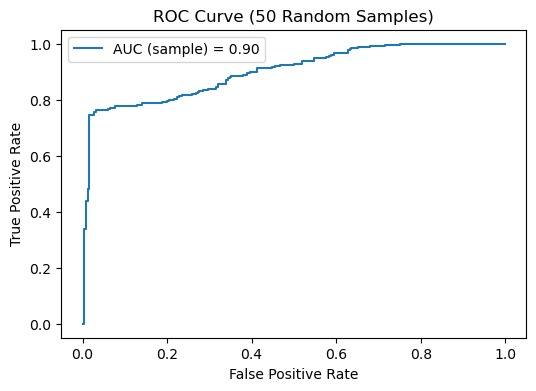

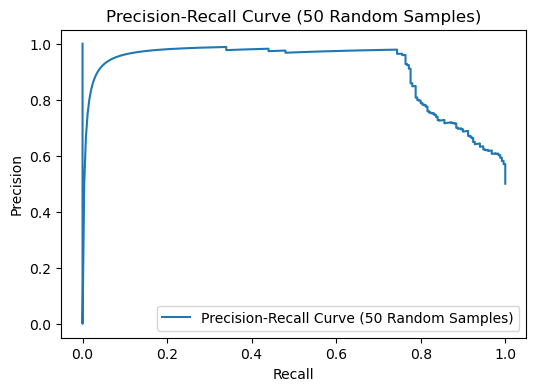

In [22]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, confusion_matrix

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

train_path = "/Users/zsigalevente/Documents/VU/year_3/P4/Machine Learning/Project/notebooks/fraud_data/fraudTrain.csv"
test_path = "/Users/zsigalevente/Documents/VU/year_3/P4/Machine Learning/Project/notebooks/fraud_data/fraudTest.csv"

train_df = pd.read_csv(train_path).sample(100000, random_state=42)
test_df = pd.read_csv(test_path)

for df in [train_df, test_df]:
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df.drop(columns=['trans_date_trans_time', 'cc_num'], inplace=True)  # Drop unused columns

numerical_features = ['amt', 'hour', 'merch_lat', 'merch_long']
categorical_features = ['category', 'job']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('under', RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
    ('over', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])


X_train = train_df.drop(columns=['is_fraud'])
y_train = train_df['is_fraud']
X_test = test_df.drop(columns=['is_fraud'])
y_test = test_df['is_fraud']


param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

halving_grid_search = HalvingGridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    factor=2,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

halving_grid_search.fit(X_train, y_train)

best_model = halving_grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

custom_threshold = 0.26

y_pred_custom = (y_proba >= custom_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_custom)

tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix (Custom Threshold):")
print(cm)
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"FP/FN Ratio: {fp / fn:.2f}")

print("\nClassification Report (Custom Threshold):")
print(classification_report(y_test, y_pred_custom))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")
fraud_indices = np.where(y_test == 1)[0]
nonfraud_indices = np.where(y_test == 0)[0]

sample_size = 500
n_fraud_samples = min(len(fraud_indices), sample_size // 2)
n_nonfraud_samples = sample_size - n_fraud_samples

random_fraud_indices = np.random.choice(fraud_indices, n_fraud_samples, replace=False)
random_nonfraud_indices = np.random.choice(nonfraud_indices, n_nonfraud_samples, replace=False)

random_indices = np.concatenate([random_fraud_indices, random_nonfraud_indices])

y_proba_sample = np.array(y_proba)[random_indices]
y_test_sample = np.array(y_test)[random_indices]

fpr, tpr, _ = roc_curve(y_test_sample, y_proba_sample)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC (sample) = {roc_auc_score(y_test_sample, y_proba_sample):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (50 Random Samples)")
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test_sample, y_proba_sample)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label="Precision-Recall Curve (50 Random Samples)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (50 Random Samples)")
plt.legend()
plt.show()


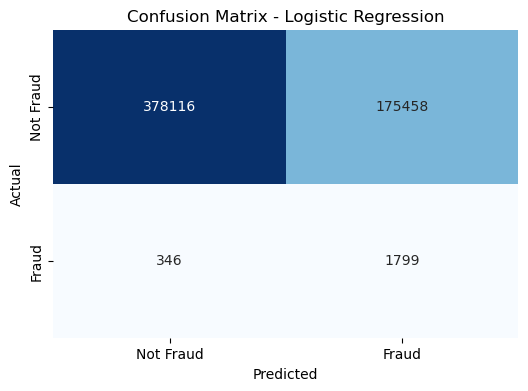

In [23]:
conf_matrix = cm
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()